# Task 6: Regularisation

_All credit for this jupyter notebook tutorial goes to the book "Hands-On Machine Learning with Scikit-Learn & TensorFlow" by Aurelien Geron. Modifications were made in preparation for the hands-on sessions._

# Setup

First, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function to save a figure. This also decides that all output files 
# should stored in the subdirectorz 'classification'.
PROJECT_ROOT_DIR = "."
EXERCISE = "regularisation"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "output", EXERCISE, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Polynomial regression

Even for non-linear data we can make use of linear regression – we simply need to add higher degrees of features to the set of features. Using those 'new' extended features, linear regression can still give us good results. Let's get started by generating some random data, with a maximum degree of 2.

In [2]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Let's have a look at how the data is distributed.

Saving figure quadratic_data_plot


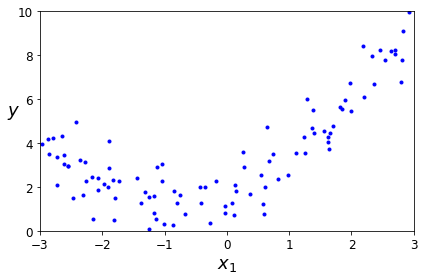

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

Now comes your first task. We would like to create a feature set which also includes all features to the power of 2. Can you create this new feature set and then perform a linear regression as we already did in the previous task? One helpful class in Scikit-Learn is the [PolynominalFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class. You will have to create an instance of that class and somehow get a 1-dimensional array of the new features. Then, you can use the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to fit.

In [4]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Let's test if that actually worked. If we look at instance 0,
# do we have the value to the power of 2 in there?
print(X[0])
print(X_poly[0])

# Now perform the linear regression.
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

# And print the fit results.
print("Fitted values: intercept = %s, coefficient = %s" % (lin_reg.intercept_[0], lin_reg.coef_[0][0]))

[-0.75275929]
[-0.75275929  0.56664654]
Fitted values: intercept = 1.7813458120291457, coefficient = 0.9336689322536068


You will see if your implementation worked with the following piece of code. It will again print the dataset created above, and then also plot the fitted model.

Saving figure quadratic_predictions_plot


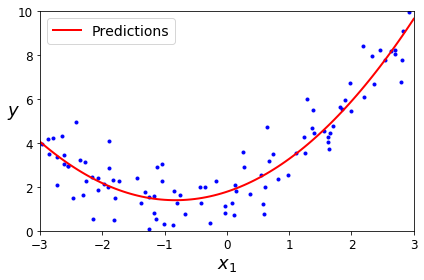

In [5]:
# Create a set of 100 X values in the interval [-3, 3], which
# is the area we want to plot, and create a 100x1 array from them.
X_new=np.linspace(-3, 3, 100).reshape(100, 1)

# Now use the PolynomialFeatures class to create a feature matrix.
X_new_poly = poly_features.transform(X_new)

# Make predictions based on this new feature matrix.
y_new = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

# Pre-step: learning curves

Before we can go into detail about the regularisation technqiues, we need to come back to another basic performance measure: the learning curve. Learning curves plot the model's performance on data with increasing size of the training set. They are particularly interesting to check convergence behaviour of the model, but also to compare the model's performance on training and validation set. Reminder: our typical cost function on the y axis is the mean squared error (MSE), or the square-root of that (RSME).

Can you try to implement the needed computation of the RSME as a function of the training set size? The first step will be to split the dataset into training and test, a good function to use for that is [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Maybe having a training:test ratio of 80:20 would be a good start. Then, create a for loop which iterates over the number of training cycles, and – for each number of cycles – make a fit with the model. Then, predict the model performance on the training set (only looking at the instances it has already seen!) and the complete validation set. You can then store the RSME values of the prediction using the [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function. We will be using the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class for the defined function, so make sure to check out the `fit` and `predict` functions.

Saving figure underfitting_learning_curves_plot


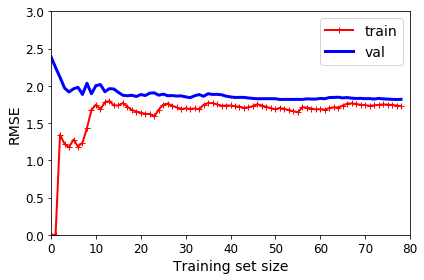

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define a function which takes a training model, and 
# our sets of X and y values.
def plot_learning_curves(model, X, y):
    # First, split into training and validation sets.
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Make sure to store the RSME values for training
    # and validation – we want to plot them later.
    train_errors, val_errors = [], []
    
    # Then start the loop, where we want to go from 1 to the
    # total number of training cycles, but for each iteration,
    # we want to evaluate the instances _up to_ that point!
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        # Perform the prediction on the (partial) training data.
        y_train_predict = model.predict(X_train[:m])
        # Perform the prediction on the (full) validation data.
        y_val_predict = model.predict(X_val)
        # Store the values into the lists.
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    # And the actual plotting commands. Plot the RSME for the
    # training set in red plus signs, and the RSME for the 
    # validation set in blue.
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

# Now create an instance of the LinearRegression class, and 
# create a plot with the function we just defined.
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

Just for the fun of it, the following code creates a polynomial set of feature up to the power of 10, which we can then fit using the LinearRegression class. Is the fitting behaviour different?

Saving figure learning_curves_plot


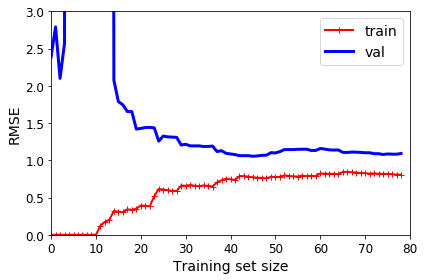

In [7]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("learning_curves_plot")
plt.show()

# Regularized models

There are two basic types of regularisation, both of which are based on mathematical norms. The first one, the Ridge regression, uses the Euclidian L2 norm. This enters the cost function for the training as an additional 'penalty' term, scaled with a parameter alpha. With small alphas, we essentially 'turn off' regularisation. Do you have an idea what happens with large values for alpha? How does the regularisation kick in?

Saving figure ridge_regression_plot_data


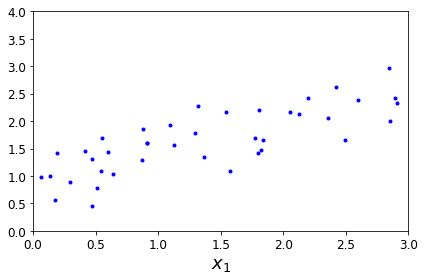

In [8]:
# Let's start by generating some random data.
np.random.seed(42)
m = 40
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 2.5

# We will need these data points later for our predictions.
X_new = np.linspace(0, 3, 100).reshape(100, 1)

# And plot it.
plt.plot(X, y, "b.", linewidth=3)
plt.xlabel("$x_1$", fontsize=18)
plt.axis([0, 3, 0, 4])
save_fig("ridge_regression_plot_data")
plt.show()

This looks like some good test data to try Ridge regularisation with. Below you can find two functions, which still have some functionality missing. Can you complete them? The first one is meant to plot linear regressions for different values of alpha, the latter the same for polynomial regression.

Saving figure ridge_regression_plot


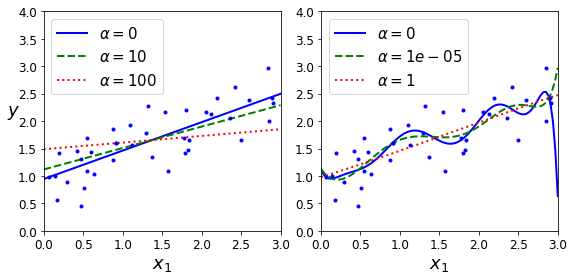

In [9]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Function to take multiple values of alpha and then
# create instances of Ridge models for each of them.
#   - model_class is a flexible parameter and could take
#     various models from sklearn.linear_model
#   - alphas should be a tuple of alpha values
def plot_model_lin(model_class, alphas):
    # Let's combine the alpha values with different plotting styles.
    alpha_styles = zip(alphas, ("b-", "g--", "r:"))
    
    # Now we can start our loop over the zipped alphas. What
    # we will need here is to instantiate a model object of
    # the desired class (maybe alo give it a fixed random_state
    # value), and then perform the fit on our X, y data. Then,
    # use the X_new to make a prediction, which we then want to
    # plot together with the data. Can you implement that?
    for alpha, style in alpha_styles:
        model = model_class(alpha, random_state=42) if alpha > 0 else LinearRegression()
        
        # Perform the fit and make a prediction.
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        
        # Plot the results.
        plt.plot(X_new, y_new_regul, style, linewidth=2, label=r"$\alpha = {}$".format(alpha))
    
    # This will also plot the data, create a legend etc.
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

# Function to take multiple values of alpha and then
# create instances of Ridge models for each of them. This
# will automatically expand the feature set with polynomial
# features up to the power of 10.
#   - model_class is a flexible parameter and could take
#     various models from sklearn.linear_model
#   - alphas should be a tuple of alpha values
#   - **model_args in case we want to forward arguments to the
#     instance of the model class (ignore this for now).
def plot_model_poly(model_class, alphas, **model_kargs):
    # Let's combine the alpha values with different plotting styles.
    alpha_styles = zip(alphas, ("b-", "g--", "r:"))
    
    # Now we can start our loop over the zipped alphas.
    for alpha, style in alpha_styles:
        model = model_class(alpha, random_state=42, **model_kargs) if alpha > 0 else LinearRegression()
        
        # This is just to make our life easier. We make a few
        # transformations of our model, by adding polynomial
        # features up the power of 10, implement a standard 
        # scaler, and eventually get back the updated model.
        # All of these could be done in individual steps, but
        # the sklearn.pipeline.Pipeline class makes this a lot
        # easier.
        model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("regul_reg", model),
            ])

        # Perform the fit and make a prediction.
        model.fit(X, y)
        y_new_regul = model.predict(X_new)

        # Plot the results.
        plt.plot(X_new, y_new_regul, style, linewidth=2, label=r"$\alpha = {}$".format(alpha))
    # This will also plot the data, create a legend etc.
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

# Now call the above functions and make two comparison plots for
# exemplary values of alpha.
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model_lin(Ridge, alphas=(0, 10, 100))
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model_poly(Ridge, alphas=(0, 10**-5, 1))

save_fig("ridge_regression_plot")
plt.show()

Looks good! To get a better idea of the predicted values, let's look at one example point at 1.5. In principle, the Ridge model can be implemented with a closed-form solution (remember the lecture), or a gradient descent method. Can you compare these two approaches? The two classes for this are [linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) and [linear_model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html), which we have both used before.

In [10]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor

# Create an instance of Ridge regression following the
# closed-form solution.
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
print("Closed form predicts: %s" % ridge_reg.predict([[1.5]])[0][0])

# Create an SGD regressor and implement Ridge regularisation.
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
print("SGD regressor predicts: %s" % sgd_reg.predict([[1.5]])[0])

Closed form predicts: 1.7188324268581745
SGD regressor predicts: 1.6910715550658264


A second regularisation technique is the Lasso regression, which uses the L2 norm (i.e. "least absolute deviations" instead of "least squares"). In case you're not, please make yourself familiar with these two norms, it is important to understand their impact on the cost function. Again, Lasso regression is implemented as a 'penalty' term with a parameter alpha to control the impact. What would be the typical behaviour of a regressor with Lasso regression implemented? Do the weights tend to be small/large? Are they equally distributed or far apart?

The following piece of code uses our previously defined functions for linear and polynomial regression, but plots Lasso regression for different values of alpha instead. Play around with those values to see what happens. We also finally get to use what we implemented earlier: we can forward additional arguments to the model. Here `tol=1` is set to one. Can you check what it does? Class reference: [linear_model.Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

Saving figure lasso_regression_plot


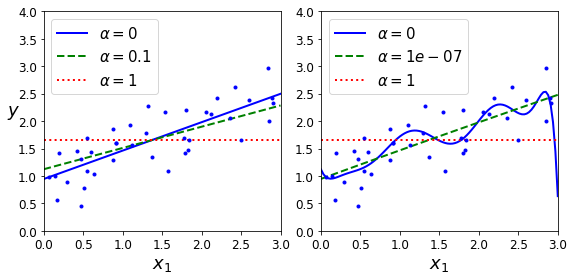

In [11]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model_lin(Lasso, alphas=(0, 0.1, 1))
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model_poly(Lasso, alphas=(0, 10**-7, 1), tol=1)

save_fig("lasso_regression_plot")
plt.show()

Now, as a last step before jumping into the next topic, it would be nice to compare the above predictions for Ridge regression with those of Lasso regression. A third model is [linear_model.ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which essentially implements the best of both worlds, i.e. it is a mixed version of L1 and L2 regularisation. Can you try to implement Lasso and ElasticNet and make a prediction for the value 1.5?

In [12]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Make a prediction with Lasso regression.
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
print("Lasso predicts: %s" % lasso_reg.predict([[1.5]])[0])

# Make a prediction with ElasticNet.
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
print("ElasticNet predicts: %s" % elastic_net.predict([[1.5]])[0])

Lasso predicts: 1.7038749273389702
ElasticNet predicts: 1.7087917962586046


# Early stopping

Another important, but completely different aspect of regularisation is 'early stopping'. The idea is to stop the training as soon as the cost function of the validation set reaches its minimum. This is basically the turning point, where the validation cost function will start to increase again and the model starts to overfit the training data. This first bit of code only visualises the idea of early stopping, but doesn't actually implement it. We will do that later. But can you add the missing parts to the code below? You might have to look into the definitions of [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [linear_model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) again for this. For the latter, please look up the `penalty` argument. What does it do? In our case, we probably want to set it to `None`. Other important arguments to look up and include are `max_iter` (how many do we want?), `eta0`, `warm_start` (do we need this?), and `learning_rate` (we want the learning rate to be constant here!).

Saving figure early_stopping_plot


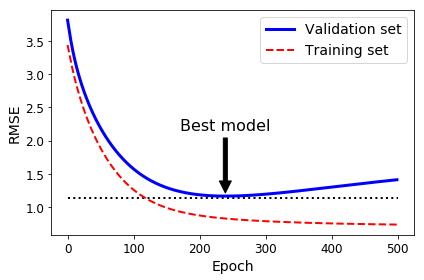

In [13]:
# Generate random data, both for training and validation.
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

# As before, we will need to split into training and validation
# set. Can you implement that? This time, maybe a ratio of 50:50
# would be desirable.
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

# Create a small pipeline which adds polynomial features to our
# feature set and applies a standard scaler (which removes the
# mean and scales to unit variance).
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

# Apply the poly_scaler pipeline to our training and validation sets.
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# Instantiate an SGDRegressor. Make sure to set the iteration
# to 1, because we want to control the number of epochs by hand
# (see below).
sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

# Create arrays to store the mean squared errors on training
# and validation data.
train_errors, val_errors = [], []

# Now let's loop over 500 epochs, fit the training data once
# per epoch, and make predictions on the training and the
# validation dataset. Remember: what is one epoch for the 
# stochastic GD method? How many instances does the model see
# per epoch?
for epoch in range(500):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    # Make predictions on training and validation.
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    # Store the mean squared errors in the arrays.
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

# Now let's get some info about the 'best' epoch. We want to
# know the epoch which had the smallest mean sqared error on
# the validation set. numpy has a function for that ... Then,
# with the best epoch extracted, we also want to know which
# value was the best.
best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

# Now this is just plotting. Make an annotation where the best
# model was actually located, and point it out in the plot.
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

# And do the plotting.
best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, 500], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

Now of couse it would be interesting to actually make the model _stop_ after the best epoch. Of course, Scikit-Learn provides functionality for that, but it's not really difficult to implement this ourselves. Let's try this in the following piece of code. So be able to save the model state after each epoch, we need to import the [base.clone](https://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html) method, which can create copies of our model instance. Can you implement the rest yourself? 

In [14]:
from sklearn.base import clone

# Instantiate an SGDRegressor. Make sure to set the iteration
# to 1, because we want to control the number of epochs by hand
# (see below). As above, also check that you set values for
# 'warm_start', 'penalty', 'learning_rate' and 'eta'.
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

# As before, we will need to split into training and validation
# set. Can you implement that? This time, maybe a ratio of 50:50
# would be desirable.
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

# Create a small pipeline which adds polynomial features to our
# feature set and applies a standard scaler (which removes the
# mean and scales to unit variance).
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

# Apply the poly_scaler pipeline to our training and validation sets.
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# Our reference value for the validation error, which we will update
# for every epoch, starting with 'inf'.
minimum_val_error = float("inf")

# Store our best epochs and model instances in these variables.
best_epoch = None
best_model = None

# Now perform the loop. Let's go through 1000 epochs. Make sure
# that the regressor continues where it left off in the epoch
# before (check the class documentation). Then, perform a fit on
# the poly-scaled version of our training data. Afterwards, make
# a prediction on our poly-scaled validation data, and store the
# mean_squared_error value of that. Is it smaller than the
# minimum value observed so far? What should we do in that case?
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    # Take appropriate actions if the observed error is smaller
    # than the one previously observed.
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

Did it work? What is the current best_epoch and best_model?

In [15]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
        verbose=0, warm_start=True))

The following (large) bit of code is directly taken from Geron's book. You don't need to understand the details of the implementation, but rather take the plots as a nice inspiration. They nicely show the different characteristics of Ridge and Lasso regression. Explanations are found below the plots. 

Saving figure lasso_vs_ridge_plot


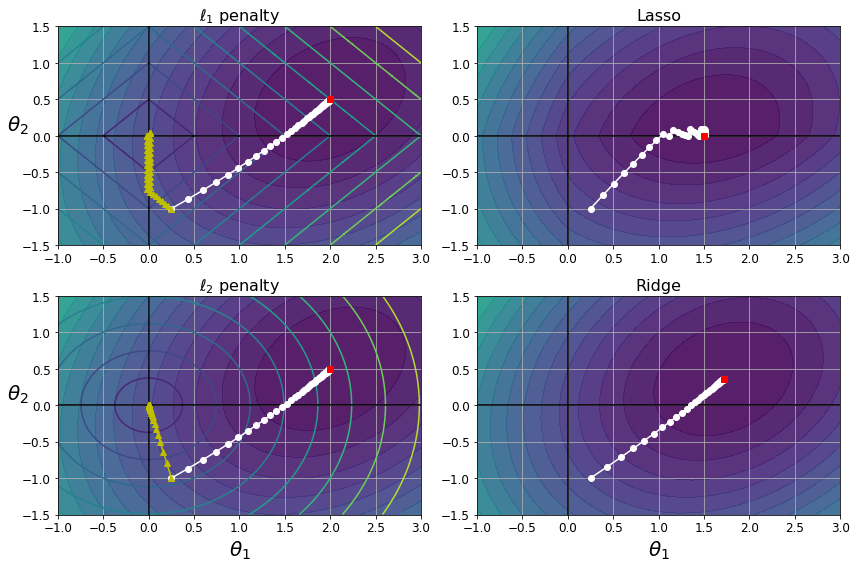

In [16]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

save_fig("lasso_vs_ridge_plot")
plt.show()

Let's start with the top left plot, on the x and y axis are two model parameters. The background ellipses (contours) show the behaviour of the MSE cost function _without_ regularisation. The foreground diamond-shaped contours represent the penalty that the L1 norm applies. The white circles represent the path that an _unregularised_ regressor would go to find the minimum (i.e. with `alpha = 0`). The yellow triangles show the path that a _purely_ penalty-based regressor would go (i.e. with `alpha -> infty`). What's interesting to see is that the regressor first 'walks back' to `theta_1 = 0`, and then walks along the y axis to reach the minimum of the diamond-shaped contours.

The ellipse contours in the top right plot show the cost function with an L1 regularisation `alpha = 0.5`. Compared to the left-hand plot, you will notice, how the global minimum is shifted to `theta_2 = 0`, and overall is closer to smaller values of `theta`. The white circles are the path the regressor would go with this regularisation term.

The two plots on the bottom show the same for Ridge regression, i.e. using L2 regularisation. First of all, notice how the contours for `alpha -> infty` on the bottom left are now circular. This also changes the path the regressor would take for a _purely_ penalty-based model: the yellow triangles show a path essentially orthogonal to the circular contour lines. 

The plot on the bottom right again shows the regression behaviour for L2 regularisation with `alpha = 0.5`. Notice how the global minimum now it _not_ at `theta_2 = 0` is it is for L1 regularisation. But still, overall it is closer to the smaller values of `theta` than in the unregularised case.